# 2021-10-13 Wave equations

## Last time

* FD methods in 2D
* Cost profile
* The need for fast algebraic solvers

## Today

* Note on p-Laplacian activity
* Weak forms and jump conditions
* 2D wave equations via gas dynamics
* Appropriate time integrators
* Hamiltonian structure and energy drift

In [1]:
using Plots
using LinearAlgebra
using SparseArrays

default(linewidth=4)

function plot_stability(Rz, title; xlims=(-2, 2), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)

function ode_rk_explicit(f, u0; tfinal=1., h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

# Weak forms

When we write

$$ {\huge "} - \nabla\cdot \big( \kappa \nabla u \big) = 0 {\huge "} \text{ on } \Omega $$

where $\kappa$ is a discontinuous function, that's not exactly what we mean.

The derivative of that discontinuous function doesn't exist!

Formally, however, let us multiply by a "test function" $v$ and integrate,

\begin{split}
  - \int_\Omega v \nabla\cdot \big( \kappa \nabla u \big) = 0 & \text{ for all } v \\
  \int_\Omega \nabla v \cdot \kappa \nabla u = \int_{\partial \Omega} v \kappa \nabla u \cdot \hat n & \text{ for all } v
\end{split}

where we have used integration by parts.  This is called the **weak form** of the PDE and will be what we actually discretize using finite element methods.  All the terms make sense when $\kappa$ is discontinuous.  

# Jump conditions

Now suppose our domain is decomposed into two disjoint sub domains $$\overline{\Omega_1 \cup \Omega_2} = \overline\Omega $$
with interface $$\Gamma = \overline\Omega_1 \cap \overline\Omega_2$$ and $\kappa_1$ is continuous on $\Omega_1$ and $\kappa_2$ is continuous on $\Omega_2$, but possibly $\kappa_1(x) \ne \kappa_2(x)$ for $x \in \Gamma$,

\begin{split}
\int_\Omega \nabla v \cdot \kappa \nabla u &= \int_{\Omega_1} \nabla v \cdot \kappa_1\nabla u + \int_{\Omega_2} \nabla v \cdot \kappa_2 \nabla u \\
&= -\int_{\Omega_1} v \nabla\cdot \big(\kappa_1 \nabla u \big) + \int_{\partial \Omega_1} v \kappa_1 \nabla u \cdot \hat n \\
&\qquad -\int_{\Omega_2} v \nabla\cdot \big(\kappa_2 \nabla u \big) + \int_{\partial \Omega_2} v \kappa_2 \nabla u \cdot \hat n \\
&= -\int_{\Omega} v \nabla\cdot \big(\kappa \nabla u \big) + \int_{\partial \Omega} v \kappa \nabla u \cdot \hat n + \int_{\Gamma} v (\kappa_1 - \kappa_2) \nabla u\cdot \hat n .
\end{split}

* Which direction is $\hat n$ for the integral over $\Gamma$?
* Does it matter what we choose for the value of $\kappa$ on $\Gamma$ in the volume integral?

When $\kappa$ is continuous, the jump term vanishes and we recover the **strong form**,
$ - \nabla\cdot \big( \kappa \nabla u \big) = 0 \text{ on } \Omega . $
But if $\kappa$ is discontinuous, we would need to augment this with a jump condition ensuring that the flux $-\kappa \nabla u$ is continuous.  We could go add this condition to our FD code to recover convergence in case of discontinuous $\kappa$, but it is messy.

# Gas equations of state

There are many ways to describe a gas

| Name | variable | units |
|------|----------|-------|
| pressure | $p$ | force/area |
| density | $\rho$ | mass/volume |
| temperature | $T$ | Kelvin |
| (specific) internal energy | $e$ | energy/mass |
| entropy | $s$ | energy/Kelvin |

## Equation of state

$$ \rho, e \mapsto p, T $$

## Ideal gas

\begin{align} p &= \rho R T & e &= e(T)
\end{align}
$$ p = (\gamma - 1) \rho e $$

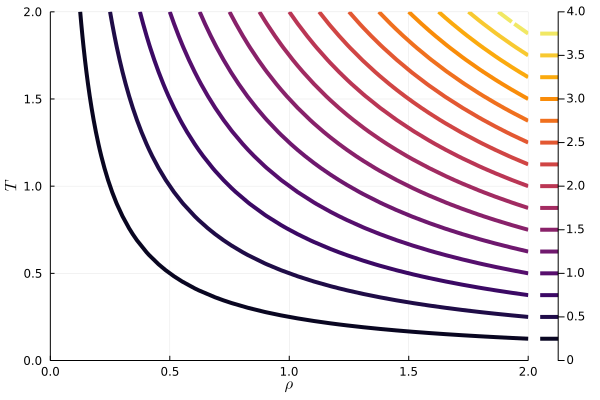

In [2]:
pressure(rho, T) = rho*T

contour(LinRange(0, 2, 30), LinRange(0, 2, 30), pressure, xlabel="\$\\rho\$", ylabel="\$T\$")

# Conservation equations

## Mass

Let $\mathbf u$ be the fluid velocity. The mass flux (mass/time) moving through an area $A$ is

$$ \int_A \rho \mathbf u \cdot \hat{\mathbf n} .$$

If mass is conserved in a volume $V$ with surface $A$, then the total mass inside the volume must evolve as

$$ \int_V \rho_t = \left( \int_V \rho \right)_t = - \underbrace{\int_A \rho\mathbf u \cdot \hat{\mathbf n}}_{\int_V \nabla\cdot (\rho\mathbf u)},$$
where we have applied the divergence theorem. Dropping the integrals over arbitrary volumes, we have the evolution equation for conservation of mass.
$$ \rho_t + \nabla\cdot (\rho \mathbf u) = 0 $$

## Momentum

The momentum $\rho \mathbf u$ has a flux that includes

* convection $\rho \mathbf u \otimes \mathbf u$
  * this is saying that each component of momentum is carried along in the vector velocity field
* pressure $p I$
* viscous $-\boldsymbol\tau$

A similar integral principle leads to the momentum equation

$$ (\rho \mathbf u)_t + \nabla\cdot\big[ \rho \mathbf u \otimes \mathbf u + p I - \boldsymbol \tau \big] = 0 $$

# Simplifications

* Ignore viscous stress tensor $\boldsymbol \tau$
* Ignore energy equation (not yet written) and assume constant temperature
  * $p = a^2 \rho$ where $a$ is the acoustic wave speed

$$\begin{pmatrix} \rho \\ \rho \mathbf u \end{pmatrix}_t + \nabla\cdot \begin{bmatrix}
\rho \mathbf u \\ \rho \mathbf u \otimes \mathbf u + \rho a^2 I \end{bmatrix} = 0 $$

## Linearization

Split each state variable into a mean state and a small fluctuation
* $\rho = \bar\rho + \tilde\rho$
* $u = \bar u + \tilde u$

Let $\widetilde{\rho u} = (\bar\rho + \tilde\rho) (\bar u + \tilde u) - \bar\rho\bar u \approx \tilde \rho \bar u + \bar\rho \tilde u$, where we have dropped the second order term $\tilde \rho\tilde u$ because both are assumed small.

We consider background state $\bar u = 0$ and constant $\bar\rho(x,y,t) = \bar\rho$. Then
$$\begin{pmatrix} \tilde \rho \\ \bar\rho \mathbf{\tilde u} \end{pmatrix}_t + \nabla\cdot \begin{bmatrix}
\bar\rho \mathbf{\tilde u} \\ \tilde \rho a^2 I \end{bmatrix} = 0 $$

# Two forms of acoustic wave equation

Divide the momentum equation through by background density and dropping the tildes yields the standard form.
$$\begin{pmatrix} \rho \\ \mathbf u \end{pmatrix}_t + \nabla\cdot \begin{bmatrix}
\bar\rho \mathbf u \\ \rho \frac{a^2}{\bar\rho} I \end{bmatrix} = 0 .$$

Examine second equation
$$ \frac{a^2}{\bar\rho} \nabla\cdot\big[ \rho I \big] = \frac{a^2}{\bar\rho} \nabla \rho $$
and thus
$$\begin{pmatrix} \rho \\ \mathbf u \end{pmatrix}_t +
\begin{bmatrix} & \bar\rho \nabla\cdot \\
\frac{a^2}{\bar\rho} \nabla & \\
\end{bmatrix}
\begin{pmatrix} \rho \\ \mathbf u \end{pmatrix} = 0.$$


Let's differentiate the first equation,
$$ \rho_{tt} + \bar\rho\nabla\cdot(\mathbf u_t) = 0$$
and substitute in the second equation
$$ \rho_{tt} = a^2 \nabla\cdot(\nabla \rho)$$

* Note: we had to assume these derivatives exist!

We can reduce this to a first order system as

$$\begin{pmatrix} \rho \\ \dot \rho \end{pmatrix}_t + \begin{bmatrix} & -I \\ -a^2 \nabla\cdot\nabla & \end{bmatrix}
\begin{pmatrix} \rho \\ \dot\rho \end{pmatrix} = 0$$

## Question
* How is the problem size different?
* What might we be concerned about in choosing the second formulation?

# Laplacian in periodic domain

In [3]:
function laplacian_matrix(n)
    h = 2 / n
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    wrap(i) = (i + n - 1) % n + 1
    idx(i, j) = (wrap(i)-1)*n + wrap(j)
    stencil_diffuse = [-1, -1, 4, -1, -1] / h^2
    for i in 1:n
        for j in 1:n
            append!(rows, repeat([idx(i,j)], 5))
            append!(cols, [idx(i-1,j), idx(i,j-1), idx(i,j), idx(i+1,j), idx(i,j+1)])
            append!(vals, stencil_diffuse)
        end
    end
    sparse(rows, cols, vals)
end

laplacian_matrix (generic function with 1 method)

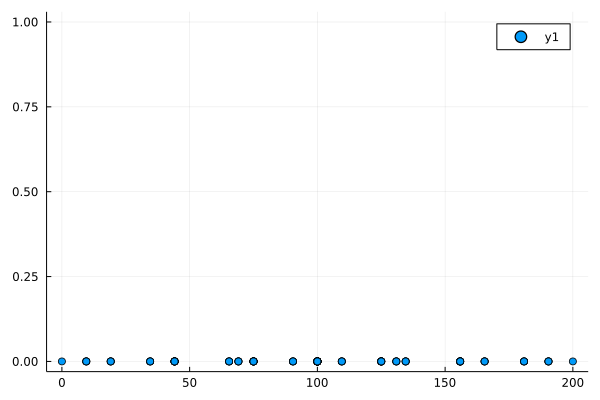

In [4]:
L = laplacian_matrix(10)
ev = eigvals(Matrix(L))
scatter(real(ev), imag(ev))

# Wave operator

$$\begin{pmatrix} \rho \\ \dot \rho \end{pmatrix}_t = \begin{bmatrix} & I \\ a^2 \nabla\cdot\nabla & \end{bmatrix}
\begin{pmatrix} \rho \\ \dot\rho \end{pmatrix}$$

In [6]:
function wave_matrix(n; a=1)
    Z = spzeros(n^2, n^2)
    L = laplacian_matrix(n)
    [Z I; -a^2*L Z]
end
wave_matrix(2)

8×8 SparseMatrixCSC{Float64, Int64} with 16 stored entries:
   ⋅     ⋅     ⋅     ⋅   1.0   ⋅    ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅    ⋅   1.0   ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅    ⋅    ⋅   1.0   ⋅ 
   ⋅     ⋅     ⋅     ⋅    ⋅    ⋅    ⋅   1.0
 -4.0   2.0   2.0    ⋅    ⋅    ⋅    ⋅    ⋅ 
  2.0  -4.0    ⋅    2.0   ⋅    ⋅    ⋅    ⋅ 
  2.0    ⋅   -4.0   2.0   ⋅    ⋅    ⋅    ⋅ 
   ⋅    2.0   2.0  -4.0   ⋅    ⋅    ⋅    ⋅ 

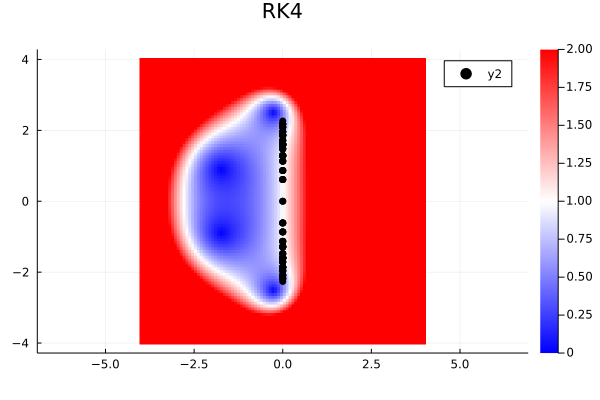

In [10]:
A = wave_matrix(8; a=2) * .1
ev = eigvals(Matrix(A))
plot_stability(z -> rk_stability(z, rk4), "RK4", xlims=(-4, 4), ylims=(-4, 4))
scatter!(real(ev), imag(ev), color=:black)

## Question: would forward Euler work?

# Example 2D wave solver with RK4

In [11]:
n = 20
A = wave_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
y = x
rho0 = vec(exp.(-9*((x .+ 1e-4).^2 .+ y'.^2)))
sol0 = vcat(rho0, zero(rho0))
thist, solhist = ode_rk_explicit((t, sol) -> A * sol, sol0, h=.02)
size(solhist)

(800, 51)

┌ Info: Saved animation to 
│   fn = /home/jed/cu/numpde/slides/tmp.gif
└ @ Plots /home/jed/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/jed/cu/numpde/slides/tmp.gif")
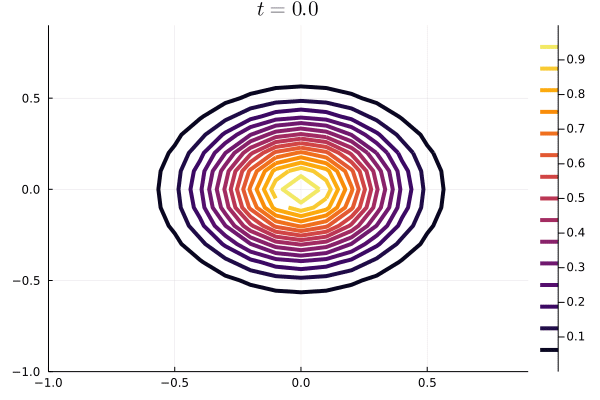

In [12]:
@gif for tstep in 1:length(thist)
    rho = solhist[1:n^2, tstep]
    contour(x, y, reshape(rho, n, n), title="\$ t = $(thist[tstep])\$")
end

# Accuracy, conservation of mass with RK4

In [16]:
thist, solhist = ode_rk_explicit((t, sol) -> A * sol, sol0, h=.05,
    tfinal=1)

tfinal = thist[end]
M = exp(Matrix(A*tfinal))
sol_exact = M * sol0
sol_final = solhist[:, end]
norm(sol_final - sol_exact)

0.02015111748435016

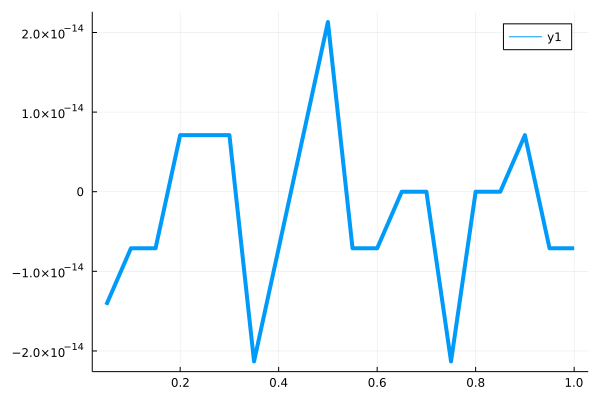

In [17]:
mass = vec(sum(solhist[1:n^2, :], dims=1))
plot(thist[2:end], mass[2:end] .- mass[1])

# Conservation of energy with RK4

## Hamiltonian structure

We can express the total energy for our system as a sum of kinetic and potential energy.

$$H(\rho, \dot\rho) = \underbrace{\frac 1 2 \int_\Omega (\dot\rho)^2}_{\text{kinetic}} + \underbrace{\frac{a^2}{2} \int_\Omega \lVert \nabla \rho \rVert^2}_{\text{potential}}$$

where we identify $\rho$ as a generalized position and $\dot\rho$ as generalized momentum. Hamilton's equations state that the equations of motion are

$$ \begin{pmatrix} \rho \\ \dot\rho \end{pmatrix}_t = \begin{bmatrix}
\frac{\partial H}{\partial \dot\rho} \\
-\frac{\partial H}{\partial \rho}
\end{bmatrix} = \begin{bmatrix}
\dot\rho \\
- a^2 L \rho
\end{bmatrix} $$
where we have used the weak form to associate $\int \nabla v \cdot \nabla u = v^T L u$.

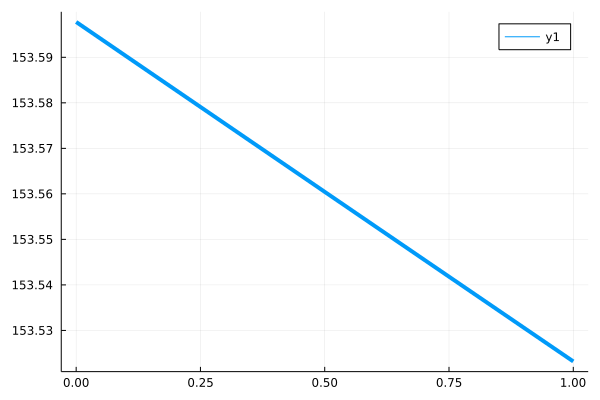

In [18]:
function energy(sol, n)
    L = laplacian_matrix(n)
    rho = sol[1:end÷2]
    rhodot = sol[end÷2+1:end]
    kinetic = .5 * norm(rhodot)^2
    potential = .5 * rho' * L * rho
    kinetic + potential
end
ehist = [energy(solhist[:,i], n) for i in 1:length(thist)]
plot(thist, ehist)

# Velocity Verlet integrator

In [19]:
function wave_verlet(n, u0; tfinal=1., h=0.1)
    L = laplacian_matrix(n)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    irho = 1:n^2
    irhodot = n^2+1:2*n^2
    accel = -L * u[irho]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        u[irho] += h * u[irhodot] + h^2/2 * accel
        accel_next = -L * u[irho]
        u[irhodot] += h/2 * (accel + accel_next)
        accel = accel_next
        t = tnext
        push!(thist, t)
        push!(uhist, copy(u))
    end
    thist, hcat(uhist...)
end

wave_verlet (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/jed/cu/numpde/slides/tmp.gif
└ @ Plots /home/jed/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/jed/cu/numpde/slides/tmp.gif")
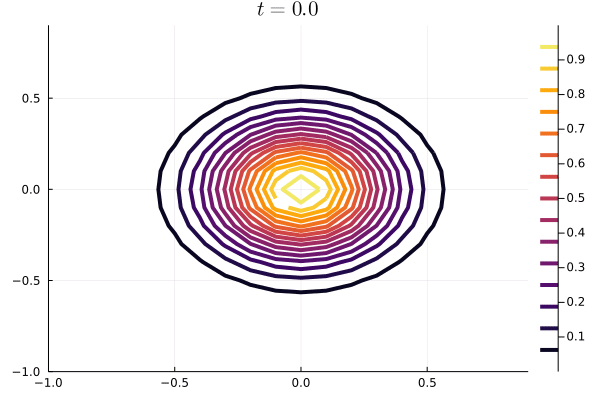

In [20]:
thist, solhist = wave_verlet(n, sol0, h=.04)
@gif for tstep in 1:length(thist)
    rho = solhist[1:n^2, tstep]
    contour(x, y, reshape(rho, n, n), title="\$ t = $(thist[tstep])\$")
end

# Accuracy and conservation for Verlet

norm(sol_final - sol_exact) = 6.86250099252766


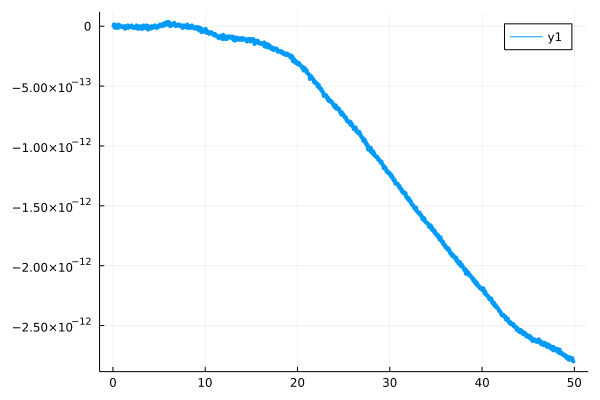

In [30]:
thist, solhist = wave_verlet(n, sol0, h=.05, tfinal=50)
tfinal = thist[end]
M = exp(Matrix(A*tfinal))
sol_exact = M * sol0
sol_final = solhist[:, end]
@show norm(sol_final - sol_exact)

mass = vec(sum(solhist[1:n^2, :], dims=1))
plot(thist[2:end], mass[2:end] .- mass[1])

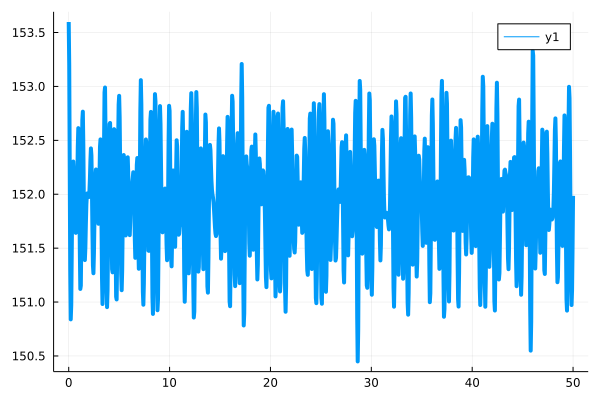

In [31]:
ehist = [energy(solhist[:,i], n) for i in 1:length(thist)]
plot(thist, ehist)

# Notes on time integrators

* We need stability on the imaginary axis for our discretization (and the physical system)
* If the model is dissipative (e.g., we didn't make the zero-viscosity assumption), then we need stability in the left half plane.
* The split form $\rho, \rho\mathbf u$ form is usually used with (nonlinear) upwinding, and thus will have dissipation.

## Runge-Kutta methods
* Easy to use, stability region designed for spatial discretization
* Energy drift generally present

## Verlet/leapfrog/Newmark and symplectic integrators

* These preserve the "geometry of the Hamiltonian"
  * energy is not exactly conserved, but it doesn't drift over time
  * such methods are called "symplectic integrators"
* May not have stability away from the imaginary axis (for dissipation)
* Most require a generalized position/momentum split, "canonical variables"